<a href="https://colab.research.google.com/github/joshdsolis/DS-Sprint-01-Dealing-With-Data/blob/master/module1-afirstlookatdata/LS_DS_111_A_First_Look_at_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [2]:
# TODO - we'll be doing this live, taking requests
# and reproducing what it is to look up and learn things
1+1

2

## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example
# There was too much code to copy and paste in one


In [5]:
# to generate gifs
!pip install imageio

    100% |████████████████████████████████| 3.3MB 8.3MB/s 
  Running setup.py bdist_wheel for imageio ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/e0/43/31/605de9372ceaf657f152d3d5e82f42cf265d81db8bbe63cde1
Successfully built imageio


In [0]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow >= 1.9 and enable eager execution
import tensorflow as tf
tfe = tf.contrib.eager
tf.enable_eager_execution()

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from IPython import display

In [7]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# Normalizing the images to the range of [0., 1.]
train_images /= 255.
test_images /= 255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

In [0]:
TRAIN_BUF = 60000
BATCH_SIZE = 100

TEST_BUF = 10000

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [0]:
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
          tf.keras.layers.Conv2D(
              filters=32, kernel_size=3, strides=(2, 2), activation=tf.nn.relu),
          tf.keras.layers.Conv2D(
              filters=64, kernel_size=3, strides=(2, 2), activation=tf.nn.relu),
          tf.keras.layers.Flatten(),
          # No activation
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation=tf.nn.relu),
          tf.keras.layers.Conv2DTranspose(
              filters=32,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation=tf.nn.relu),
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
        ]
    )

  def sample(self, eps=None):
    if eps is None:
      eps = tf.random_normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random_normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

In [0]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

def compute_gradients(model, x):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  return tape.gradient(loss, model.trainable_variables), loss

optimizer = tf.train.AdamOptimizer(1e-4)
def apply_gradients(optimizer, gradients, variables, global_step=None):
  optimizer.apply_gradients(zip(gradients, variables), global_step=global_step)

In [0]:
epochs = 100
latent_dim = 50
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random_normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model.sample(test_input)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Epoch: 15, Test set ELBO: -89.03877288818359, time elapse for current epoch 100.30018854141235


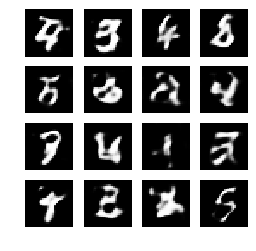

In [0]:
generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    gradients, loss = compute_gradients(model, train_x)
    apply_gradients(optimizer, gradients, model.trainable_variables)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tfe.metrics.Mean()
    for test_x in test_dataset.make_one_shot_iterator():
      loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
    generate_and_save_images(
        model, epoch, random_vector_for_generation)

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

I looked at a project generating hand-written numbers. The hand-written numbers were generated via  tf.Keras and Eager mode.
They trained a Variational Autoencoder, a magic data science program, to do it.

2.  What was the most challenging part of what you did?

The most challenging part was deciphering the code. I still haven't fully deciphered it.

3.  What was the most interesting thing you learned?

I learned about generation and how complex something relatively simple can be, such as generating written digits.

4.  What area would you like to explore with more time?

I'd like to explore more about generated images. There was a post in the channel about AI generated art, and I found it interesting.


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about